# CE 5362 Lesson 8 Unsteady Open Channel Flow
---

Implement Lax-Scheme using an example problem

## Finite-Difference Method for Unsteady Open Channel Flow

Solving the St. Venant Equations is accomplished by mapping the physical system and the set of partial differential equations into an algebraic structure that a computer can  manipulate.   Finite-difference,  finite-element,  finite-volume,  and  marker-in-cell are the typical methods.  

The simplest form of solution that is conditionally stable and reasonably straightforward to program is called the Lax-Diffusion scheme.  This  scheme  is  reasonably  accurate  and  useful  for  practical  problems  as  well  as  to learn what goes on under the hood of a professional tool like SWMM or HEC-RAS.

Recall our difference equations derived from continunity:

\begin{equation}
\begin{matrix}
y_i^{t+\Delta t} = \frac{1}{2}(y_{i-1}^t+y_{i+1}^t) -\frac{r}{2}(\frac{A}{B}\vert_{i-1}^t + \frac{A}{B}\vert_{i+1}^t)(V_{i+1}^{t}-V_{i-1}^t)-\frac{r}{2}(V_{f,i-1}^t + V_{f,i+1}^t)(y_{i+1}^{t}-y_{i-1}^t) \\
~\\
 \end{matrix}
 \label{eqn:lax-continunity}
\end{equation}



and momentum:

\begin{equation}
\begin{matrix}
V_i^{t+\Delta t}=\frac{1}{2}(V_{i-1}^t+V_{i+1}^t) +
\Delta t  g(S_0-\frac{1}{2}(S_{f,i-1}^t + S_{f,i+1}^t))
- \frac{r}{2}(V_{i-1}^t+V_{i+1}^t) (V_{i+1}^{t}-V_{i-1}^t)
-rg(y_{i+1}^{t}-y_{i-1}^t)\\
~\\
\end{matrix}
\label{eqn:lax-momentum}
\end{equation}

## Example/Problem Statement

The backwater curve situation for a rectangular channel with discharge over a weir is repeated.  The channel width is 5 meters, bottom slope $0.001$, Manning's $n=0.02$ and discharge $Q=55.4 \frac{m^3}{sec}$.

We will build a transient solver, although this problem is a steady flow case that we can check with an independent tool (Hamming's approach a few lessons ago).  We will start with the flow depth artificially large and observe the transient solver evolve eventually produce an equilibrium solution that should be the same as the steady-flow solver.  

Generally such a simulation is a good idea to test a new algorithm -- it should be stable enough to converge to and maintain a steady solution.

Why we would consider a transient solver is to examine cases such as that depicted in Figure 1

![](tidal-bore-14[8].jpg)

|Figure 1. Image of a tidal bore propagating upstream|
|:---|



The remainder of this notebook will develop a script that implements these concepts.




## Building a Tool

The script is comprised of several parts, and eventually for the sake of taking advantage of the ability to read and operate on files, the script will have several "libraries" that are read by a main control program.  

The main program controls the overall solution process, while the library functions can be built and tested in advance.  What follows is a port from an old FORTRAN and later R program that is specific to this problem, we will get it working first, then generalize for reuse.



In [273]:
import math

In [274]:
# hydraulic functions 
# depth == flow depth          
# bottom == bottom width of trapezoidal channel
# side == side slope (same value both sides) of trapezoidal channel
# computed values:
# bt == computed topwidth :: ar == flow area, used in fd update :: wp == wetted perimeter, used in fd update

def bt(depth,bottom,side):   # depth-topwidth function
    topwidth = (bottom + 2.0*side*depth);
    return(topwidth);

def ar(depth,bottom,side):  # depth area function
    area = (depth*(bottom+side*depth));
    return(area)

def wp(depth,bottom,side):   # depth perimeter
    import math
    perimeter = (bottom+2.0*depth*math.sqrt(1.0+side*side));
    return(perimeter)

In [286]:
###### Problem Constants #######
# these are constants that define the problem
# change for different problems
# a good habit is to assign constants to names so the
# program is readable by people in a few years
g = 9.81 # gravitational acceleration, obviously SI units
n = 10 # number of reaches
q0 = 55.4 # initial discharge
yd = 8.000 # initial flow depth in the model
yu = 5.000 # upstream constant depth
mn = 0.020 # Manning's n
b0 = 5 # bottom width
s0 = 0.001 # longitudinal slope (along direction of flow)
s  = 0.0 # side slope (passed to calls to hydraulic variables)
l  = 11380.0 # total length (the lenght of computational domain)
tmax = 6000 # total simulation time in seconds
iprt =  1 # print every iprt time steps
nn = n+1 # how many nodes, will jack with boundaries later
mn2 = mn*mn # Manning's n squared, will appear a lot.
a = ar(yd,b0,s) # flow area at beginning of time
v0 = q0/a # initial velocity

In [287]:
######## Here we build storage vectors ###############
y = [0]*nn # create nn elements of vector y, all zero
yp = [0]*nn # updates go in this vector, same length as y
v = [0]*nn # create nn elements of vector v
vp = [0]*nn # updates go in this vector, same length and v
b = [0]*nn
ytmp = [0]*nn
vtmp = [0]*nn
y = [float(yd) for i in y] # populate y with nn things, each thing has value yd
v = [float(v0) for i in y] # populate v with nn things, each thing has value v0

In [288]:
b = bt(y[0],b0,s) # topwidth at downstream end
c = math.sqrt(g*a/b) # celerity at initial conditions
dx = l/n # delta x, length of a reach
#dx

In [289]:
xx = [dx*(i) for i in range(0,nn)] # Spatial locations of nodes, used for plotting

In [290]:
bse = [12 - s0*xx[i] for i in range(0,nn)] # bottom channel elevation
wse = [bse[i]+y[i] for i in range(0,nn)] # water surface elevation
dt = dx/(v0 + c) # the time step that satisfies the courant condtions
kmax = round(tmax/dt)  # set maximum number of time steps

In [297]:
bse

[12.0,
 10.862,
 9.724,
 8.586,
 7.4479999999999995,
 6.31,
 5.172,
 4.034,
 2.895999999999999,
 1.7579999999999991,
 0.6199999999999992]

In [292]:
print('Celerity = ',round(c,3) )
print('Delta x  = ',round(dx,3))
print('Delta t  = ',round(dt,3))
print("ITmax = ",(kmax))

Celerity =  8.859
Delta x  =  1138.0
Delta t  =  111.091
ITmax =  54


The next set of functions are prototype functions for reporting the output -- it will be cleaner to build the output functions separate from the control program, and send the necessary vectors when we want to actually print results.

In [293]:
# display functions 
import matplotlib

def writenow(t,dt,y,v,b0,s): # printing functions
    print("__________")
    print("Time = ",t," seconds.","Time step length = ",dt," seconds ")
    print("IROW "," DEPTH "," VELOCITY ")
    for irow in range(0,len(v)):
        print(irow,round(y[irow],3),round(v[irow],3))
    return()  #observe a NULL return, this function messages to the output device, so there is nothing to return.

def plot2lines(list1,list2,list3,list4,strx,stry,strtitle): # plot list1 on x, list2 on y, xlabel, ylabel, title
    from matplotlib import pyplot as plt # import the plotting library from matplotlibplt.show()
    plt.plot( list1, list2, color ='brown', marker ='*', linestyle ='solid') # create a line chart, years on x-axis, gdp on y-axis
    plt.plot( list3, list4, color ='blue', marker ='o', linestyle ='solid') # create a line chart, years on x-axis, gdp on y-axis
    plt.title(strtitle)# add a title
    plt.ylabel(stry)# add a label to the x and y-axes
    plt.xlabel(strx)
    plt.show() # display the plot
    return #null return

In [294]:
k = 0 # time counter
t = 0.0 # elapsed time
writenow(t,dt,y,v,b0,s) #print the start conditions

__________
Time =  0.0  seconds. Time step length =  111.09056948493378  seconds 
IROW   DEPTH   VELOCITY 
0 8.0 1.385
1 8.0 1.385
2 8.0 1.385
3 8.0 1.385
4 8.0 1.385
5 8.0 1.385
6 8.0 1.385
7 8.0 1.385
8 8.0 1.385
9 8.0 1.385
10 8.0 1.385


()

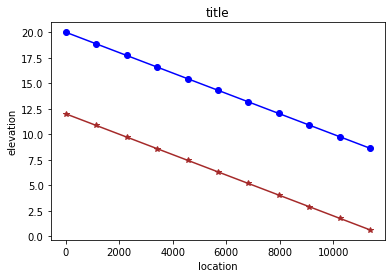

In [295]:
plot2lines(xx,bse,xx,wse,"location","elevation","title")

__________
Time =  111.09056948493378  seconds. Time step length =  111.09056948493378  seconds 
IROW   DEPTH   VELOCITY 
0 5.0 -1.202
1 8.0 2.121
2 8.0 2.121
3 8.0 2.121
4 8.0 2.121
5 8.0 2.121
6 8.0 2.121
7 8.0 2.121
8 8.0 2.121
9 8.0 2.121
10 8.0 1.385
__________
Time =  214.73785829048302  seconds. Time step length =  103.64728880554924  seconds 
IROW   DEPTH   VELOCITY 
0 5.0 -0.959
1 5.454 -0.469
2 8.0 2.363
3 8.0 2.363
4 8.0 2.363
5 8.0 2.363
6 8.0 2.363
7 8.0 2.363
8 8.0 2.363
9 8.268 2.276
10 8.0 1.385
__________
Time =  315.60779448162975  seconds. Time step length =  100.86993619114675  seconds 
IROW   DEPTH   VELOCITY 
0 5.0 -0.131
1 5.45 -0.277
2 5.776 0.221
3 8.0 2.416
4 8.0 2.416
5 8.0 2.416
6 8.0 2.416
7 8.0 2.416
8 8.138 2.304
9 8.347 2.316
10 8.0 1.385
__________
Time =  415.7422920060513  seconds. Time step length =  100.13449752442155  seconds 
IROW   DEPTH   VELOCITY 
0 5.0 0.088
1 5.303 0.686
2 5.808 0.332
3 6.094 0.723
4 8.0 2.427
5 8.0 2.427
6 8.0 2.427
7 8.095 

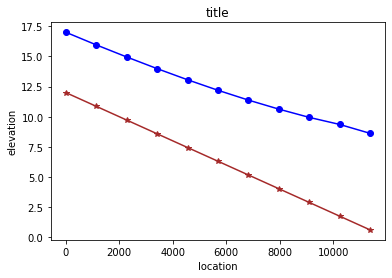

In [296]:
for itime in range(0,kmax): # begin time stepping loop scope
#print('Iteration Count = ',itime)
######## Adaptive Time Step Based on Current mesh courant number ###
    bestdt = dt # start with current time step
### begin courant number each cell loop scope
    for i in range(0,nn):
        a = ar(y[i],b0,s);
        b = bt(y[i],b0,s);
        c = math.sqrt(g*a/b);
        dtn = dx/abs((v[i])+c)
    # now test
        if(dtn < bestdt):
            bestdt = dtn
### end courant number each cell loop scope
    dt = bestdt
#print('time-step length = ',dt)
#writenow(t,dt,y,v,b0,s)


###### Finite Difference #################################
    r = 0.5*dt/dx;
###### LEFT BOUNDARY #####################################
# UPSTREAM FIXED STAGE AT PRESCRIBED NORMAL DEPTH        #
##########################################################
    yp[0] = yu
    ab = ar(y[1],b0,s);
    bb = bt(y[1],b0,s);
    cb = math.sqrt(g*bb/ab);
    rb = ab/wp(y[1],b0,s);
    sfb = (mn2*v[1]*v[1])/(rb**(1.333));
    cn = v[1] -cb*y[1]+ g*(s0-sfb)*dt;
    vp[0] = cn + cb*yp[0];
###### RIGHT BOUNDARY ####################################
#         FIXED STAGE AT DOWNSTREAM END                  #
##########################################################
# reflection boundary, find velocity along a characteristic
    yp[n-1] = yd ;
    aa = ar(y[n-1],b0,s);
    ba = bt(y[n-1],b0,s);
    ca = math.sqrt(g*ba/aa);
    ra = aa/wp(y[n-1],b0,s);
    sfa = (mn2*v[n-1]*v[n-1])/(ra**(4.0/3.0));
    cp = v[n-1] + ca*y[n-1]+g*(s0-sfa)*dt;
##yp[nn] <<- (cp - vp[nn])/ca;
    vp[n] = cp - yp[n]*ca 
######## INTERIOR NODES AND REACHES ###############
### loop through the interior nodes
    for i in range(1,n): # begin interior node loop scope
        aa = ar(y[i-1],b0,s);
        ba = bt(y[i-1],b0,s);
        pa = wp(y[i-1],b0,s);
        ra = aa/pa;
        sfa = (mn2*v[i-1]*v[i-1])/(ra**(4.0/3.0));
        ab = ar(y[i+1],b0,s);
        bb = bt(y[i+1],b0,s);
        pb = wp(y[i+1],b0,s);
        rb = ab/pb;
        sfb = (mn2*v[i+1]*v[i+1])/(rb**(4.0/3.0));
# need averages of sf, hydraulic depth
        dm = 0.5*(aa/ba + ab/bb);
        sfm = 0.5*(sfa+sfb);
        vm = 0.5*(v[i-1]+v[i+1]);
        ym = 0.5*(y[i-1]+y[i+1]);
# new momentum
        vp[i] = vm -r*g*(y[i+1] - y[i-1]) -r*vm*(v[i+1] - v[i-1]) + g*dt*(s0-sfm);
# new depth
        yp[i] = ym - r*dm*(v[i+1] - v[i-1]) -r*vm*(y[i+1] - y[i-1]);
### end of interior node loop scope
# update time, count, depth and momentum
    t = t+dt; # Increment simulation time
    k = k+1; # Increment loop counter
    for i in range(0,n):
        v[i]=vp[i]
        y[i]=yp[i]
    if (k%iprt == 0): # Write current conditions every iprt time steps
        writenow(t,dt,y,v,b0,s)
    dt = 2*dt #artificially inflate the time step to force adaptive update
# end time step loop

# provisional code to make a plot

for i in range(0,nn):
    wse[i]=bse[i]+y[i]
plot2lines(xx,bse,xx,wse,"location","elevation","title")